# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import heapq

# Grid Visualization Class

In [2]:
# Visualization Function plots the grid and the found path.
def visualize_grid_and_path(grid, path, battery_levels):
    grid_array = np.array(grid)  # Convert grid to numpy array for easy plotting.
    fig, ax = plt.subplots()

    #If path is found then show it in grid
    if path:
      ax.imshow(grid_array, cmap='summer', alpha=0.8)  # Grid background.
      start = path[0]
      goal = path[-1]
      ax.plot(start[1], start[0], 'ys', markersize=10)  # Start position in blue.
      ax.plot(goal[1], goal[0], 'rs', markersize=10)  # Goal position in green.
      xs, ys = zip(*path)  # Extract X and Y coordinates of the path.
      ax.plot(ys, xs, 'y-', linewidth=2)  # Plot the path in red.

      # Plot battery levels
    for state, level in battery_levels.items():
        ax.text(state[1], state[0], f'{level}', ha='center', va='center', fontsize=8, color='white')

    #if path in not found, show empty grid
    else:
      ax.imshow(grid_array, cmap='summer', alpha=0.8)

    ax.set_xticks(np.arange(-.5, len(grid[0]), 1), minor=True)
    ax.set_yticks(np.arange(-.5, len(grid), 1), minor=True)
    ax.grid(which="minor", color="orange", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", size=0)
    ax.tick_params(which="major", bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.show()

# Priority Class

In [3]:
class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]

# Node Class

In [4]:
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0, battery_level = 100):
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.battery_level = battery_level

    def __lt__(self, other):
        return self.path_cost < other.path_cost

# Heuristic Method for A* Algorithm

In [5]:
def heuristic(a, b):
    """
    Calculate the Manhattan distance between two points a and b.

    Parameters:
    - a: Tuple representing the x and y coordinates of point a (e.g., (x1, y1))
    - b: Tuple representing the x and y coordinates of point b (e.g., (x2, y2))

    Returns:
    - The Manhattan distance between points a and b.
    """
    (x1, y1) = a
    (x2, y2) = b
    return abs(x1 - x2) + abs(y1 - y2)


# Environment Class

In [6]:
class Environment:
    def __init__(self, grid, start, goal):
        self.grid = grid
        self.initial = start
        self.goal = goal

    def actions(self, state):
        possible_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        x, y = state

        if x == 0 or self.grid[x - 1][y] == 1:
            possible_actions.remove('UP')
        if x == len(self.grid) - 1 or self.grid[x + 1][y] == 1:
            possible_actions.remove('DOWN')
        if y == 0 or self.grid[x][y - 1] == 1:
            possible_actions.remove('LEFT')
        if y == len(self.grid[0]) - 1 or self.grid[x][y + 1] == 1:
            possible_actions.remove('RIGHT')

        return possible_actions

    def result(self, state, action):
        x, y = state
        if action == 'UP':
            return (x - 1, y)
        if action == 'DOWN':
            return (x + 1, y)
        if action == 'LEFT':
            return (x, y - 1)
        if action == 'RIGHT':
            return (x, y + 1)

    def is_goal(self, state):
        return state == self.goal

# Agent Class

In [29]:
class Agent:
    def __init__(self, env):
        self.env = env

    def ucs(self):
        frontier = PriorityQueue()
        frontier.put(Node(self.env.initial, path_cost=0, battery_level=100), 0)
        came_from = {self.env.initial: None}
        cost_so_far = {self.env.initial: 0}
        battery_levels = {self.env.initial: 100}
        recharge_needed = 0

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state), battery_levels, recharge_needed

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1
                new_battery = current_node.battery_level - 10

                if new_battery <= 0:
                  new_battery = 100
                  recharge_needed += 1

                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost
                    frontier.put(Node(new_state, current_node, action, new_cost, new_battery), priority)
                    came_from[new_state] = current_node.state
                    battery_levels[new_state] = new_battery

        return []

    def a_star_search(self):
        # The start node is created with a path cost of 0.
        start_node = Node(self.env.initial, path_cost=0, battery_level=100)
        frontier = PriorityQueue()
        frontier.put(start_node, 0)  # Priority is f-cost, initially the heuristic cost from start to goal
        came_from = {self.env.initial: None}  # Tracks the best path to a node
        cost_so_far = {self.env.initial: 0}  # Tracks the g-cost (cost so far to reach a node)
        battery_levels = {self.env.initial: 100}
        recharge_needed = 0

        while not frontier.empty():
            current_node = frontier.get()

            if self.env.is_goal(current_node.state):
                return self.reconstruct_path(came_from, current_node.state), battery_levels, recharge_needed

            for action in self.env.actions(current_node.state):
                new_state = self.env.result(current_node.state, action)
                new_cost = cost_so_far[current_node.state] + 1  # Assuming uniform cost for simplicity
                new_battery = current_node.battery_level - 10

                if new_battery <= 0:
                  new_battery = 100
                  recharge_needed += 1

                if new_state not in cost_so_far or new_cost < cost_so_far[new_state]:
                    cost_so_far[new_state] = new_cost
                    priority = new_cost + heuristic(new_state, self.env.goal)  # f-cost = g-cost + h-cost
                    frontier.put(Node(new_state, current_node, action, new_cost, new_battery), priority)
                    came_from[new_state] = current_node.state
                    battery_levels[new_state] = new_battery

        return []


    def reconstruct_path(self, came_from, current):
        path = []
        while current in came_from:
            path.append(current)
            current = came_from[current]
        path.append(self.env.initial)
        path.reverse()
        return path

# Generate Random Grid Class

In [8]:
def generate_random_grid(size, obstacle_probability):
    return np.random.choice([0, 1], size=(size, size), p=[1-obstacle_probability, obstacle_probability])

# Setting Up Grid Size

In [9]:

# Define the size of the grid and the probability of an obstacle in each cell
grid_size = 10
obstacle_probability = 0.2  # 20% chance of being an obstacle


# Generating Random Grid

In [15]:
# Generate a random grid
grid = generate_random_grid(grid_size, obstacle_probability)

# Define start and goal positions
start = (0, 0)
goal = (grid_size - 1, grid_size - 1)

# Ensure start and goal are not obstacles
grid[start] = 0
grid[goal] = 0

# Simulation using UCS and A* Algorithm

# Simulation using UCS

Recharge needed: 13 times


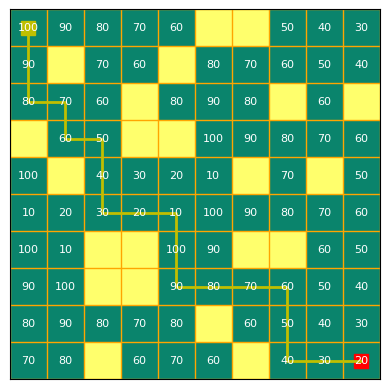

In [32]:

# Create the environment and agent
environment = Environment(grid, start, goal)
agent = Agent(environment)

# Solve the problem with Uniform Cost Search
solution_path, battery_levels, recharge_needed = agent.ucs()
if solution_path == []:
  print("Path blocked with obstacles, unable to find path")
  visualize_grid_and_path(grid, solution_path, battery_levels)
else:
  # Visualize the solution
  print(f'Recharge needed: {recharge_needed} times')
  visualize_grid_and_path(grid, solution_path, battery_levels)


# Simulation Using A* Algorithm

Recharge needed: 7 times


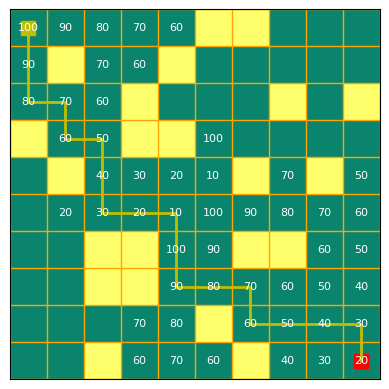

In [31]:

# Create the environment and agent
environment = Environment(grid, start, goal)
agent = Agent(environment)

# Solve the problem with A* Search
solution_path, battery_levels, recharge_needed = agent.a_star_search()
if solution_path == []:
  print("Path blocked with obstacles, unable to find path")
  visualize_grid_and_path(grid, solution_path, battery_levels)
else:
  # Visualize the solution
  print(f'Recharge needed: {recharge_needed} times')
  visualize_grid_and_path(grid, solution_path, battery_levels)